In [1]:
import Dates
println("Last updated: ", Dates.now())

Last updated: 2020-07-15T15:28:47.586


In [2]:
# Load environment
import Pkg; Pkg.activate("../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [28]:
# Import Libraries
using Turing
using Turing: Variational
using Turing.RandomMeasures: stickbreak
using Distributions
using Distances
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux
import LinearAlgebra

┌ Info: Precompiling Distances [b4f34e82-e78d-54a5-968a-f98e89d6e8f7]
└ @ Base loading.jl:1260


In [147]:
function quantiles(X, q; dims, drop=false)
  Q = mapslices(x -> quantile(x, q), X, dims=dims)
  out = drop ? dropdims(Q, dims=dims) : Q
  return out
end
function make_extractor(m, q, nsamples=1000)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end

make_extractor (generic function with 3 methods)

In [4]:
# function neural_net(x, w1, b1, w2, b2)
#     z = sigmoid.(x * w1 .+ b1)
#     return z * w2 .+ b2
# end

# neural_net(randn(10, 2), randn(2, 5), randn(1, 5), randn(5,1), randn(1, 1))
# neural_net(randn(10, 2), randn(2, 5), randn(1, 5), randn(5,2), randn(1, 2))

function neural_net(x, w1, b1, w2, b2)
    z = sigmoid.(w1 * x .+ b1)
    return w2 * z .+ b2
end

# nn_shapes(n, k, u, o) = (u, k), u, (o, u), o
# n, k, u, o = 10, 2, 5, 2
# neural_net(randn(k, n), randn(nn_shapes(n,k,u,o)[1]), randn(u), randn(o, u), randn(o))

neural_net (generic function with 1 method)

In [5]:
function bivnormlogpdf(x, m, S)
    K = length(m)
    invS = inv(S)
    z = (x - m)
    log_numer = -z' * invS * z / 2
    log_denom = 0.5 * (K * log(2*pi) + LinearAlgebra.logdet(S))
    return sum(log_numer) - log_denom
end

eye(n::Int) = Matrix{Float64}(LinearAlgebra.I, n, n);

In [6]:
function make_cov(sigx, sigy, rho)
    c = sigx * sigy * rho
    sx2 = sigx*sigx
    sy2 = sigy*sigy
    return reshape([sx2, c, c, sy2], 2, 2)
end

# inv(make_cov(rand()*2, rand()*2, rand()*2 - 1))

make_cov (generic function with 1 method)

In [7]:
struct MvGMM <: ContinuousMultivariateDistribution
    mu # Matrix{Float64}
    Sigma # Vector{Matrix{Float64}}
    w # Vector{Float64}
end

1000-element Array{Float64,1}:
 0.712559844973676
 0.4369869792036772
 0.6427986819499688
 0.33614401592069576
 0.6218581700011083
 0.3515972759834186
 0.4869536984555852
 0.38061402876256956
 0.5102126366142834
 0.7691034608020205
 0.46030453839351937
 0.5828090916816624
 0.8018831876107811
 ⋮
 0.682116984638312
 0.26249266397609555
 0.5241725146074381
 0.7242471304959238
 0.478306513826238
 0.527019501826063
 0.3085759632703777
 0.281454906504844
 0.2713288699227262
 0.3876984266382781
 0.49256688743099497
 0.3532771848088731

In [8]:
function Distributions.rand(rng::Random.AbstractRNG, d::MvGMM)
    D, K = size(d.mu)  # dimension x num_components
    k = rand(Categorical(d.w)) 
    return rand(MvNormal(d.mu[:, k], d.Sigma[k]))
end

function Distributions.logpdf(d::MvGMM, x::AbstractVector{<:Real})
    D, K = size(d.mu)  # dimension x num_components
    ll = [logpdf(MvNormal(d.mu[:, k], d.Sigma[k]), x) for k in 1:K]
    return logsumexp(ll .+ log.(d.w))
end

Bijectors.bijector(d::MvGMM) = Identity{1}()

# Example:
# Sigma = [make_cov(.5, .5, .5) for _ in 1:5]
# mvgmm = MvGMM(randn(2,5), Sigma, stickbreak(rand(4)))
# x = rand(mvgmm)
# logpdf(mvgmm, x)

In [12]:
function unpack(θ::AbstractVector, network_shape::AbstractVector)
    index = 1
    weights = []
    biases = []
    for layer in network_shape
        rows, cols, _ = layer
        size = rows * cols
        last_index_w = size + index - 1
        last_index_b = last_index_w + rows
        push!(weights, reshape(θ[index:last_index_w], rows, cols))
        push!(biases, reshape(θ[last_index_w+1:last_index_b], rows))
        index = last_index_b + 1
    end
    return weights, biases
end
function nn_forward(x, θ::AbstractVector, network_shape::AbstractVector)
    weights, biases = unpack(θ, network_shape)
    layers = []
    for i in eachindex(network_shape)
        push!(layers, Dense(weights[i],
            biases[i],
            eval(network_shape[i][3])))
    end
    nn = Chain(layers...)
    return nn(x)
end

# network_shape = [(7, 2, :σ), (2, 7, :σ)]
# x = randn(2, 10)
# num_params = sum([i * o + i for (i, o, _) in network_shape])
# theta = randn(num_params)
# nn_forward(x, theta, network_shape)

nn_forward (generic function with 1 method)

In [9]:
# DP GMM model under stick-breaking construction
# FIXME: Look at the very round-about way to do NN below.
@model function warped_mixture(Y, K, num_units, ::Type{T}=Matrix{Float64}) where T
    D, nobs = size(Y)
    network_shape = [(num_units, D, :tanh), (D, num_units, :tanh)]
    num_params = sum([i * o + i for (i, o, _) in network_shape])
    
    # Mixture weights.
    alpha ~ Uniform(0, 1)
    v ~ filldist(Beta(1, alpha), K - 1)
    eta = stickbreak(v)
    
    # Neural net parameters.
    theta ~ filldist(Normal(0, 1), num_params) 
    
    # Mixture parameters
    mu ~ filldist(Normal(0, 1), D, K)
    R ~ LKJ(D, 1.0)
    sigma ~ LogNormal(-1, 1)

    # Latent variables.
    x = T(undef, D, nobs)
    for i in 1:nobs
        x[:, i] ~ MvGMM(mu, [R for _ in 1:K], eta)
    end
    
    # Latent variables.
    z = nn_forward(x, theta, network_shape)
    
    # Turing.acclogp!(_varinfo, sum(normlogpdf.(z, sigma, Y)))
    for d in 1:D
        Y[d, :] ~ MvNormal(z[d, :], sigma)
    end
end

DynamicPPL.ModelGen{var"###generator#427",(:Y, :K, :num_units, :T),(:T,),Tuple{Type{Array{Float64,2}}}}(##generator#427, NamedTuple{(:T,),Tuple{Type{Array{Float64,2}}}}((Array{Float64,2},)))

In [13]:
Y = randn(2, 100)
m = warped_mixture(Y, 5, 7)  # data, num_components, nn_num_units

# q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
# advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
# @time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-2));

chain = sample(m, HMC(0.01, 100), 100)

MethodError: MethodError: no method matching bijector(::LKJ{Float64,Int64})
Closest candidates are:
  bijector(!Matched::KSOneSided) at /home/ubuntu/.julia/packages/Bijectors/66bcj/src/transformed_distribution.jl:58
  bijector(!Matched::MvGMM) at In[8]:13
  bijector(!Matched::Product{Discrete,T,V} where V<:AbstractArray{T,1} where T<:Distribution{Univariate,Discrete}) at /home/ubuntu/.julia/packages/Bijectors/66bcj/src/transformed_distribution.jl:39
  ...

In [13]:
# muladd(randn(3,6), randn(6), randn(3))

3-element Array{Float64,1}:
 -0.08483072775939038
 10.460685913113892
  1.260316822109702

In [236]:
get_network_shape(num_units, data_dim) = [(num_units, P, :tanh), (1, num_units, :tanh)]

@model function bnn(y, X, num_units) where T
    nobs, P = size(X)
    network_shape = [(num_units, P, :tanh), (1, num_units, :tanh)]
    num_params = sum([i * o + i for (i, o, _) in network_shape])
    
    # Neural net parameters.
    nn_params ~ filldist(Normal(0, 1), num_params)
    
    # Latent variables.
    z = nn_forward(X', nn_params, network_shape)
    
    # Model noise
    sigma ~ LogNormal(-1, 1)
   
    # Turing.acclogp!(_varinfo, sum(normlogpdf.(z, sigma, y)))
    y ~ MvNormal(vec(z), sigma * eye(nobs))
end

DynamicPPL.ModelGen{var"###generator#1953",(:y, :X, :num_units),(),Tuple{}}(##generator#1953, NamedTuple())

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:01:50


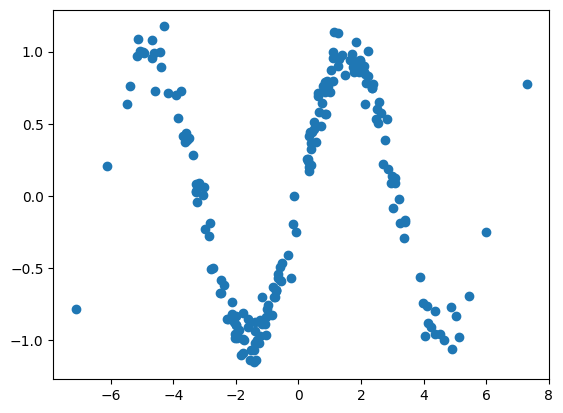

110.930964 seconds (5.34 M allocations: 81.013 GiB, 6.97% gc time)


In [260]:
N = 200
X = randn(N, 1) * 3
y = sin.(vec(X)) + randn(N) * 0.1
plt.scatter(vec(X), y)
m = bnn(y, X, 5)  # data, num_components, nn_num_units
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
@time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-1));

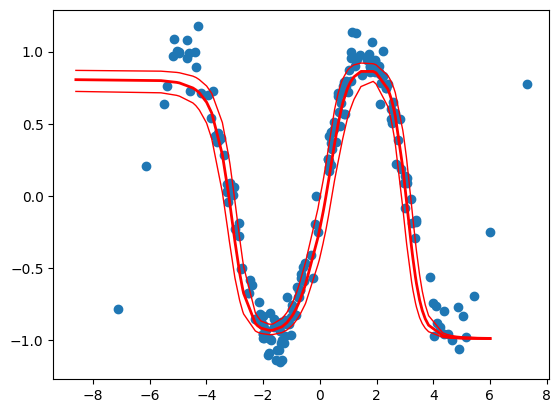

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fde4fd9b160>

In [271]:
nsamples = 1000
iqsamples = rand(q, nsamples)
_, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
extract(sym) = qsamples[collect(sym2range[sym][1]), :]

nn_params = extract(:nn_params)
num_units=5
network_shape = [(num_units, 1, :tanh), (1, num_units, :tanh)]
num_params = sum([i * o + i for (i, o, _) in network_shape])
x = sort(randn(100, 1) * 3, dims=1)
preds = [nn_forward(x', nn_params[:, i], network_shape) for i in 1:nsamples]
preds = vcat(preds...)

plt.scatter(vec(X), y)
plt.plot(x, vec(quantiles(preds, 0.975, dims=1)), color="red", lw=1)
plt.plot(x, vec(mean(preds, dims=1)), color="red", lw=2)
plt.plot(x, vec(quantiles(preds, 0.025, dims=1)), color="red", lw=1)

In [181]:
sqexp_cov_fn(D, phi, eps=1e-3) = exp.(-D^2 / phi) + LinearAlgebra.I * eps
exp_cov_fn(D, phi) = exp.(-D / phi)

@model function GP(y, X, m=0, s=1, cov_fn=exp_cov_fn)
    N, P = size(X)
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    mu ~ Normal(m, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)
    K = cov_fn(D, phi)
    
    y ~ MvNormal(mu * ones(N), K + sig2 * LinearAlgebra.I(N))
end

DynamicPPL.ModelGen{var"###generator#780",(:y, :X, :m, :s, :cov_fn),(:m, :s, :cov_fn),Tuple{Int64,Int64,typeof(exp_cov_fn)}}(##generator#780, (m = 0, s = 1, cov_fn = exp_cov_fn))

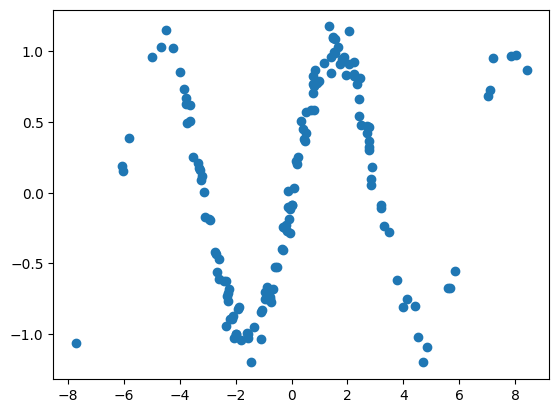

PyObject <matplotlib.collections.PathCollection object at 0x7f7dbbebcc50>

In [182]:
N = 150
X = randn(N, 1) * 3
y = sin.(vec(X)) + randn(N) * 0.1
plt.scatter(vec(X), y)

In [183]:
m = GP(y, X)  # data, num_components, nn_num_units
q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
@time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-1));

 23.267353 seconds (8.85 M allocations: 15.271 GiB, 6.17% gc time)


In [184]:
extract_gp = make_extractor(m, q)
mu = vec(extract_gp(:mu))
sig2 = vec(extract_gp(:sig2))
phi = vec(extract_gp(:phi));

In [185]:
function make_gp_predict(Xnew, y, X, cov_fn)
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)
    
    return (mu, sig2, phi) -> let
        K = cov_fn(D, phi)
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * (y .- mu) .+ mu
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        # Base.show(stdout, "text/plain", S[1:3, 1:3])
        mvn = MvNormal(m, S + sig2 * LinearAlgebra.I)
        rand(mvn)
    end
end

make_gp_predict (generic function with 2 methods)

In [186]:
Xnew = sort(randn(N, 1) * 4, dims=1)
gp_predict = make_gp_predict(Xnew, y, X, exp_cov_fn)
ynew = [gp_predict(mu[m], sig2[m], phi[m]) for m in 1:length(mu)]
ynew = hcat(ynew...);

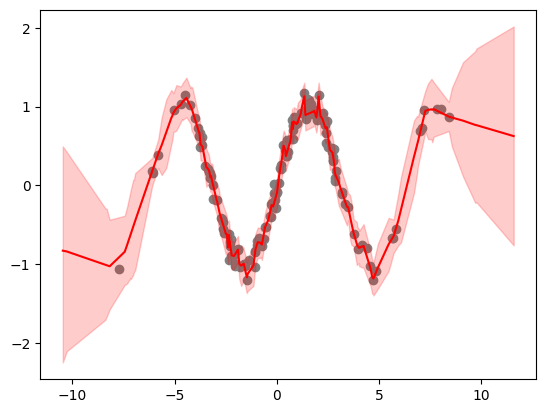

PyObject <matplotlib.collections.PolyCollection object at 0x7f7dbbe15898>

In [187]:
pred_mean = mean(ynew, dims=2)
pred_lower = quantiles(ynew, 0.025, dims=2)
pred_upper = quantiles(ynew, 0.975, dims=2)
plt.plot(vec(Xnew), vec(pred_mean), color="red")
plt.scatter(vec(X), vec(y), color="grey")
plt.fill_between(vec(Xnew), vec(pred_upper), vec(pred_lower), color="red", alpha=0.2)

In [190]:
function mvnorm_mix_logpdf(x, mu, Sigma, w)
    D, K = size(mu)  # dimension x num_components
    ll = [logpdf(MvNormal(mu[:, k], Sigma[k]), x) for k in 1:K]
    return logsumexp(ll .+ log.(w))
end

mvnorm_mix_logpdf (generic function with 1 method)

In [285]:
@model function warped_gp_mixture(Y, nmix=5, cov_fn=exp_cov_fn)
    nobs, nfeatures = size(Y)
    
    v ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)
    w ~ Dirichlet(nmix, 1.0/nmix)
    
    mu = Matrix{Float64}(undef, nfeatures, nmix)
    Sigma = Vector{Matrix{Float64}}(undef, nmix)
    for k in 1:nmix
        mu[:, k] ~ MvNormal(zeros(2), 1.0)
        Sigma[k] ~ InverseWishart(nfeatures + 2.0, eye(nfeatures))
    end
    
    X = Matrix{Float64}(undef, nobs, nfeatures)
    
    for i in 1:nobs
        # Turing.acclogp!(_varinfo, mvnorm_mix_logpdf(X[i, :], mu, Sigma, w))
        X[i, :] ~ MvGMM(mu, Sigma, w)
    end
    
    for d in 1:nfeatures
        D = pairwise(Euclidean(), X, dims=1)
        Cd = Matrix(LinearAlgebra.Hermitian(cov_fn(D, -phi)))
        y[:, d] ~ MvNormal(zeros(nobs), Cd + LinearAlgebra.I * v)
        println("HERE3")
    end
end

DynamicPPL.ModelGen{var"###generator#1418",(:Y, :nmix, :cov_fn),(:nmix, :cov_fn),Tuple{Int64,typeof(exp_cov_fn)}}(##generator#1418, (nmix = 5, cov_fn = exp_cov_fn))

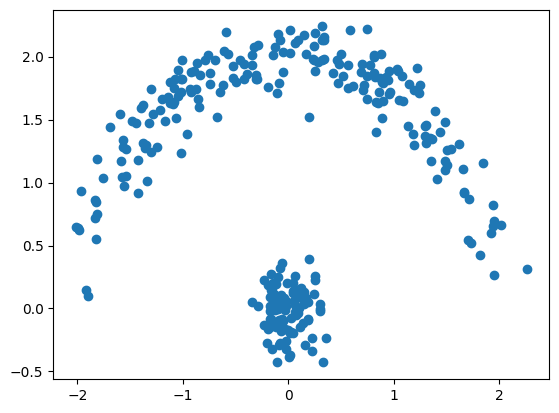

PyObject <matplotlib.collections.PathCollection object at 0x7f7dbb1fec50>

In [286]:
# Warped Data
function make_warped_data(n1=100, n2=200, r=2, s=0.15)
    Y1 = zeros(n1, 2)
    x2 = rand(n2) * r * 2 .- r
    y2 = sqrt.(r .^ 2 .- x2 .^ 2)
    Y2 = [x2 y2]
    return [Y1; Y2] + randn(n1 + n2, 2) * s
end
Y_warped = make_warped_data()
plt.scatter(Y_warped[:, 1], Y_warped[:, 2])

In [287]:
Random.seed!(0)
m = warped_gp_mixture(Y_warped, 5)  # data, num_components, nn_num_units
# q0 = Variational.meanfield(m)  # initialize variational distribution (optional)
# advi = ADVI(1, 2000)  # num_elbo_samples, max_iters
# @time q = vi(m, advi, q0, optimizer=Flux.ADAM(1e-1));

In [288]:
varinfo = Turing.VarInfo(m)
spl = Turing.SampleFromPrior()
@code_warntype model.f(m, varinfo, spl, Turing.DefaultContext())

LinearAlgebra.PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.